In [1]:
import pandas as pd

df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


In [2]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [3]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len) + 1

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 17


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

In [5]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12197


In [6]:
# TEST
import tensorflow as tf

def format_dataset(en, fr):
    return ({ 'encoder_inputs': en, 'decoder_inputs': fr[:, :-1] }, fr[:, 1:])

#en_texts, fr_texts = zip(en_x, fr_y)
#en_texts = list(en_texts)
#fr_texts = list(fr_texts)
#dataset = tf.data.Dataset.from_tensor_slices((en_x, fr_y))
#dataset = dataset.batch(50)
#dataset = dataset.map(format_dataset)
#dataset = dataset.prefetch(25).cache()

In [7]:
inputs = { 'encoder_inputs': en_x, 'decoder_inputs': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

## Build and train a model

In [8]:
from transformer import *

embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype='int64', name='encoder_inputs')
x = PositionalEmbedding(sequence_len, en_vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype='int64', name='decoder_inputs')
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name='decoder_state_inputs')
x = PositionalEmbedding(sequence_len, fr_vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
#x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(fr_vocab_size, activation='softmax')(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name='transformer'
)

transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transformer.summary(line_length=120)

Model: "transformer"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 encoder_inputs (InputLayer)           [(None, None)]             0             []                                      
                                                                                                                        
 positional_embedding (PositionalEmbed  (None, None, 256)         1548800       ['encoder_inputs[0][0]']                
 ding)                                                                                                                  
                                                                                                                        
 decoder_inputs (InputLayer)           [(None, None)]             0             []                                      
           

In [9]:
#from keras.utils.vis_utils import plot_model

#plot_model(transformer, show_shapes=True, show_layer_names=True)

In [10]:
hist = transformer.fit(inputs, outputs, epochs=25, validation_split=0.2)

Epoch 1/25
1250/1250 [==============================] - 243s 193ms/step - loss: 0.9844 - accuracy: 0.5717 - val_loss: 0.7214 - val_accuracy: 0.6492
Epoch 2/25
1250/1250 [==============================] - 240s 192ms/step - loss: 0.5364 - accuracy: 0.7019 - val_loss: 0.5722 - val_accuracy: 0.6991
Epoch 3/25
1250/1250 [==============================] - 242s 193ms/step - loss: 0.3737 - accuracy: 0.7551 - val_loss: 0.5424 - val_accuracy: 0.7205
Epoch 4/25
1250/1250 [==============================] - 238s 190ms/step - loss: 0.2954 - accuracy: 0.7859 - val_loss: 0.5453 - val_accuracy: 0.7280
Epoch 5/25
1250/1250 [==============================] - 243s 194ms/step - loss: 0.2502 - accuracy: 0.8109 - val_loss: 0.5405 - val_accuracy: 0.7356
Epoch 6/25
1250/1250 [==============================] - 239s 191ms/step - loss: 0.2216 - accuracy: 0.8272 - val_loss: 0.5357 - val_accuracy: 0.7409
Epoch 7/25
1250/1250 [==============================] - 239s 191ms/step - loss: 0.2029 - accuracy: 0.8375 - val_

[]

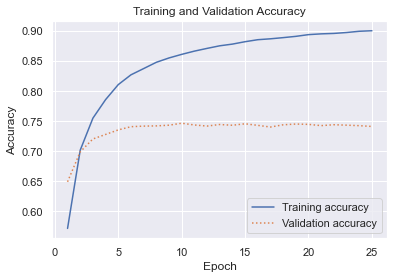

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [41]:
fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))

def decode_sequence(input_sentence, en_tokenizer, fr_tokenizer, fr_index_lookup):
    print(f'Input sentence: {input_sentence}')
    #print(f'Input sentence length: {len(input_sentence)}')
    input_sequence = en_tokenizer.texts_to_sequences(input_sentence)
    print(f'Input sequence: {input_sequence}')
    print(f'Input sequence length: {len(input_sequence)}')
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    print(f'sequence_len: {sequence_len}')
    print(f'Padded input sequence length: {len(padded_input_sequence)}')
    decoded_sentence = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences(decoded_sentence)
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]
        print(len(padded_target_sequence))
        
        predictions = transformer([padded_input_sequence, padded_target_sequence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += ' ' + sampled_token

        if sampled_token == '[end]':
            break
    
    return decoded_sentence

#test_eng_texts = [pair[0] for pair in test_pairs]
texts = en[40000:40010].values

for i in range(len(texts)):
    input_sentence = texts[i]
    translated = decode_sequence(input_sentence, en_tokenizer, fr_tokenizer, fr_index_lookup)
    print(translated)

Input sentence: its fall now
Input sequence: [[1], [], [], [], [], [4], [], [], [], [], [], []]
Input sequence length: 12
sequence_len: 17
Padded input sequence length: 12
7


InvalidArgumentError: Exception encountered when calling layer "multi_head_attention_2" (type MultiHeadAttention).

Expected dimension 12 at axis 0 of the input shaped [7,16,8,256] but got dimension 7 [Op:Einsum]

Call arguments received:
  • query=tf.Tensor(shape=(7, 16, 256), dtype=float32)
  • value=tf.Tensor(shape=(12, 17, 256), dtype=float32)
  • key=tf.Tensor(shape=(12, 17, 256), dtype=float32)
  • attention_mask=tf.Tensor(shape=(7, 16, 16), dtype=int32)
  • return_attention_scores=False
  • training=False

In [14]:
import numpy as np

texts = en[40000:40010].values
sequences = en_tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=sequence_len, padding='post')
predictions = transformer.predict(padded_sequences)

for i in range(len(predictions)):
    indexes = [np.argmax(idx) for idx in predictions[i]]
    translated_text = fr_tokenizer.sequences_to_texts([indexes])[0]
    print(f'{texts[i]} => {translated_text}')

ValueError: in user code:

    File "c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "transformer" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 17) dtype=int32>]
